In [1]:
import pandas as pd
import numpy as np
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from sklearn.model_selection import KFold
## 0. 打印设置
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)  ## 显示全部结果，不带省略点
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)
import pandas as pd
from matplotlib import  pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost
import datetime
%matplotlib inline

In [2]:
# 1. 概况分析
# 1.1 读取数据
x_train = pd.read_csv(r'./data/train.csv')
x_test = pd.read_csv(r'./data/test.csv')

In [3]:
# 1.2 概况预览
def overViewAnalysis1(dataframe):
    print('----------------整体概况----------------')
    overview = pd.DataFrame()
    overview['type'] = dataframe.dtypes
    overview['row_nums'] = dataframe.shape[0]
    overview['null_nums'] = dataframe.isnull().sum()
    # overview['min_num'] = dataframe.min()
    # overview['max_num'] = dataframe.max()
    overview['mean_num'] = dataframe.describe().loc['mean']
#     overview['std_num'] = dataframe.describe().loc['std']

    for col in dataframe.columns:
        overview.loc[col,'nunique_nums'] = dataframe[col].nunique()

    print(overview)
    print('----------------整体概况----------------')

In [4]:
overViewAnalysis1(x_train)

----------------整体概况----------------
                                type  row_nums  null_nums   mean_num  nunique_nums
policy_id                      int64       700          0  549624.98        700.00
age                            int64       700          0      38.65         45.00
customer_months                int64       700          0     205.30        332.00
policy_bind_date              object       700          0        NaN        674.00
policy_state                  object       700          0        NaN          3.00
policy_csl                    object       700          0        NaN          3.00
policy_deductable              int64       700          0    1147.86          3.00
policy_annual_premium        float64       700          0    1246.55        698.00
umbrella_limit                 int64       700          0 1100000.00         11.00
insured_zip                    int64       700          0  502796.82        699.00
insured_sex                   object       700    

In [5]:
## 2. 数据EDA探索
## 2.1 数据清洗
# 0） 空值处理，不需要
# 1) 日期转换,加入后，得分下降
# policy_bind_date, incident_date
for data in x_train,x_test:
    data['incident_date'] = pd.to_datetime(data['incident_date'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2022-06-30', '%Y-%m-%d')
    data['time'] = data['incident_date'].apply(lambda x: startdate-x).dt.days
    

In [6]:
overViewAnalysis1(x_train)

----------------整体概况----------------
                                       type  row_nums  null_nums                       mean_num  nunique_nums
policy_id                             int64       700          0                      549624.98        700.00
age                                   int64       700          0                          38.65         45.00
customer_months                       int64       700          0                         205.30        332.00
policy_bind_date                     object       700          0                            NaN        674.00
policy_state                         object       700          0                            NaN          3.00
policy_csl                           object       700          0                            NaN          3.00
policy_deductable                     int64       700          0                        1147.86          3.00
policy_annual_premium               float64       700          0                   

In [5]:
# 2） 数据编码
Ca_feature = list(x_train.select_dtypes(include=['object']).columns)
lb = LabelEncoder()
for col in Ca_feature:
    x_train[col] = lb.fit_transform(x_train[col])
    x_test[col] = lb.fit_transform(x_test[col])
overViewAnalysis1(x_train)

----------------整体概况----------------
                                type  row_nums  null_nums   mean_num  nunique_nums
policy_id                      int64       700          0  549624.98        700.00
age                            int64       700          0      38.65         45.00
customer_months                int64       700          0     205.30        332.00
policy_bind_date               int32       700          0     336.00        674.00
policy_state                   int32       700          0       0.95          3.00
policy_csl                     int32       700          0       0.91          3.00
policy_deductable              int64       700          0    1147.86          3.00
policy_annual_premium        float64       700          0    1246.55        698.00
umbrella_limit                 int64       700          0 1100000.00         11.00
insured_zip                    int64       700          0  502796.82        699.00
insured_sex                    int32       700    

In [6]:
x_train

,policy_id,age,customer_months,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud
0,122576,37,189,629,2,2,1000,1465.71,5000000,455456,0,5,10,15,1,62203,0,15,2,3,2,0,4,5,21,1,0,0,3,0,54930,6029,5752,44452,9,26,2000,0
1,937713,44,234,233,1,1,500,821.24,0,591805,1,3,2,14,2,31606,0,73,0,3,1,2,4,6,4,3,0,2,1,2,50680,5376,10156,37347,6,10,1996,0
2,680237,33,23,175,1,2,1000,1844.00,0,442490,0,2,6,16,5,0,-43166,42,2,3,2,3,2,3,0,1,0,2,1,1,47829,4460,9247,33644,7,36,2002,0
3,513080,42,210,516,0,2,500,1867.29,0,439408,1,3,13,18,3,0,-49440,57,0,1,0,1,2,3,20,3,2,2,2,2,68862,11043,5955,53548,11,21,2003,1
4,192875,29,81,334,0,0,1000,816.25,0,640575,0,4,2,18,3,75296,-73689,64,0,2,2,1,1,3,9,3,2,2,1,2,59726,5617,10301,41550,5,14,2004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1008425,37,196,216,2,1,500,1301.20,0,474615,1,3,12,18,5,47627,0,42,2,1,0,0,4,1,4,1,0,0,3,1,61433,10436,11432,39745,9,29,2011,1
696,770702,43,229,312,0,1,500,1434.94,8000000,444476,1,1,6,9,0,0,-32289,37,0,2,0,0,0,0,17,3,1,0,1,0,68623,6798,14557,50606,13,28,2013,1
697,755099,35,209,359,2,0,500,1639.46,0,639608,0,1,13,9,1,0,-40797,88,0,2,1,1,1,5,7,3,1,2,0,2,58033,9129,4598,40740,8,7,2002,0
698,693804,44,275,376,1,2,2000,1042.29,0,432061,0,0,6,13,2,46822,0,33,0,2,0,0,4,3,20,3,0,1,0,1,35253,7359,3464,24677,1,4,2007,1


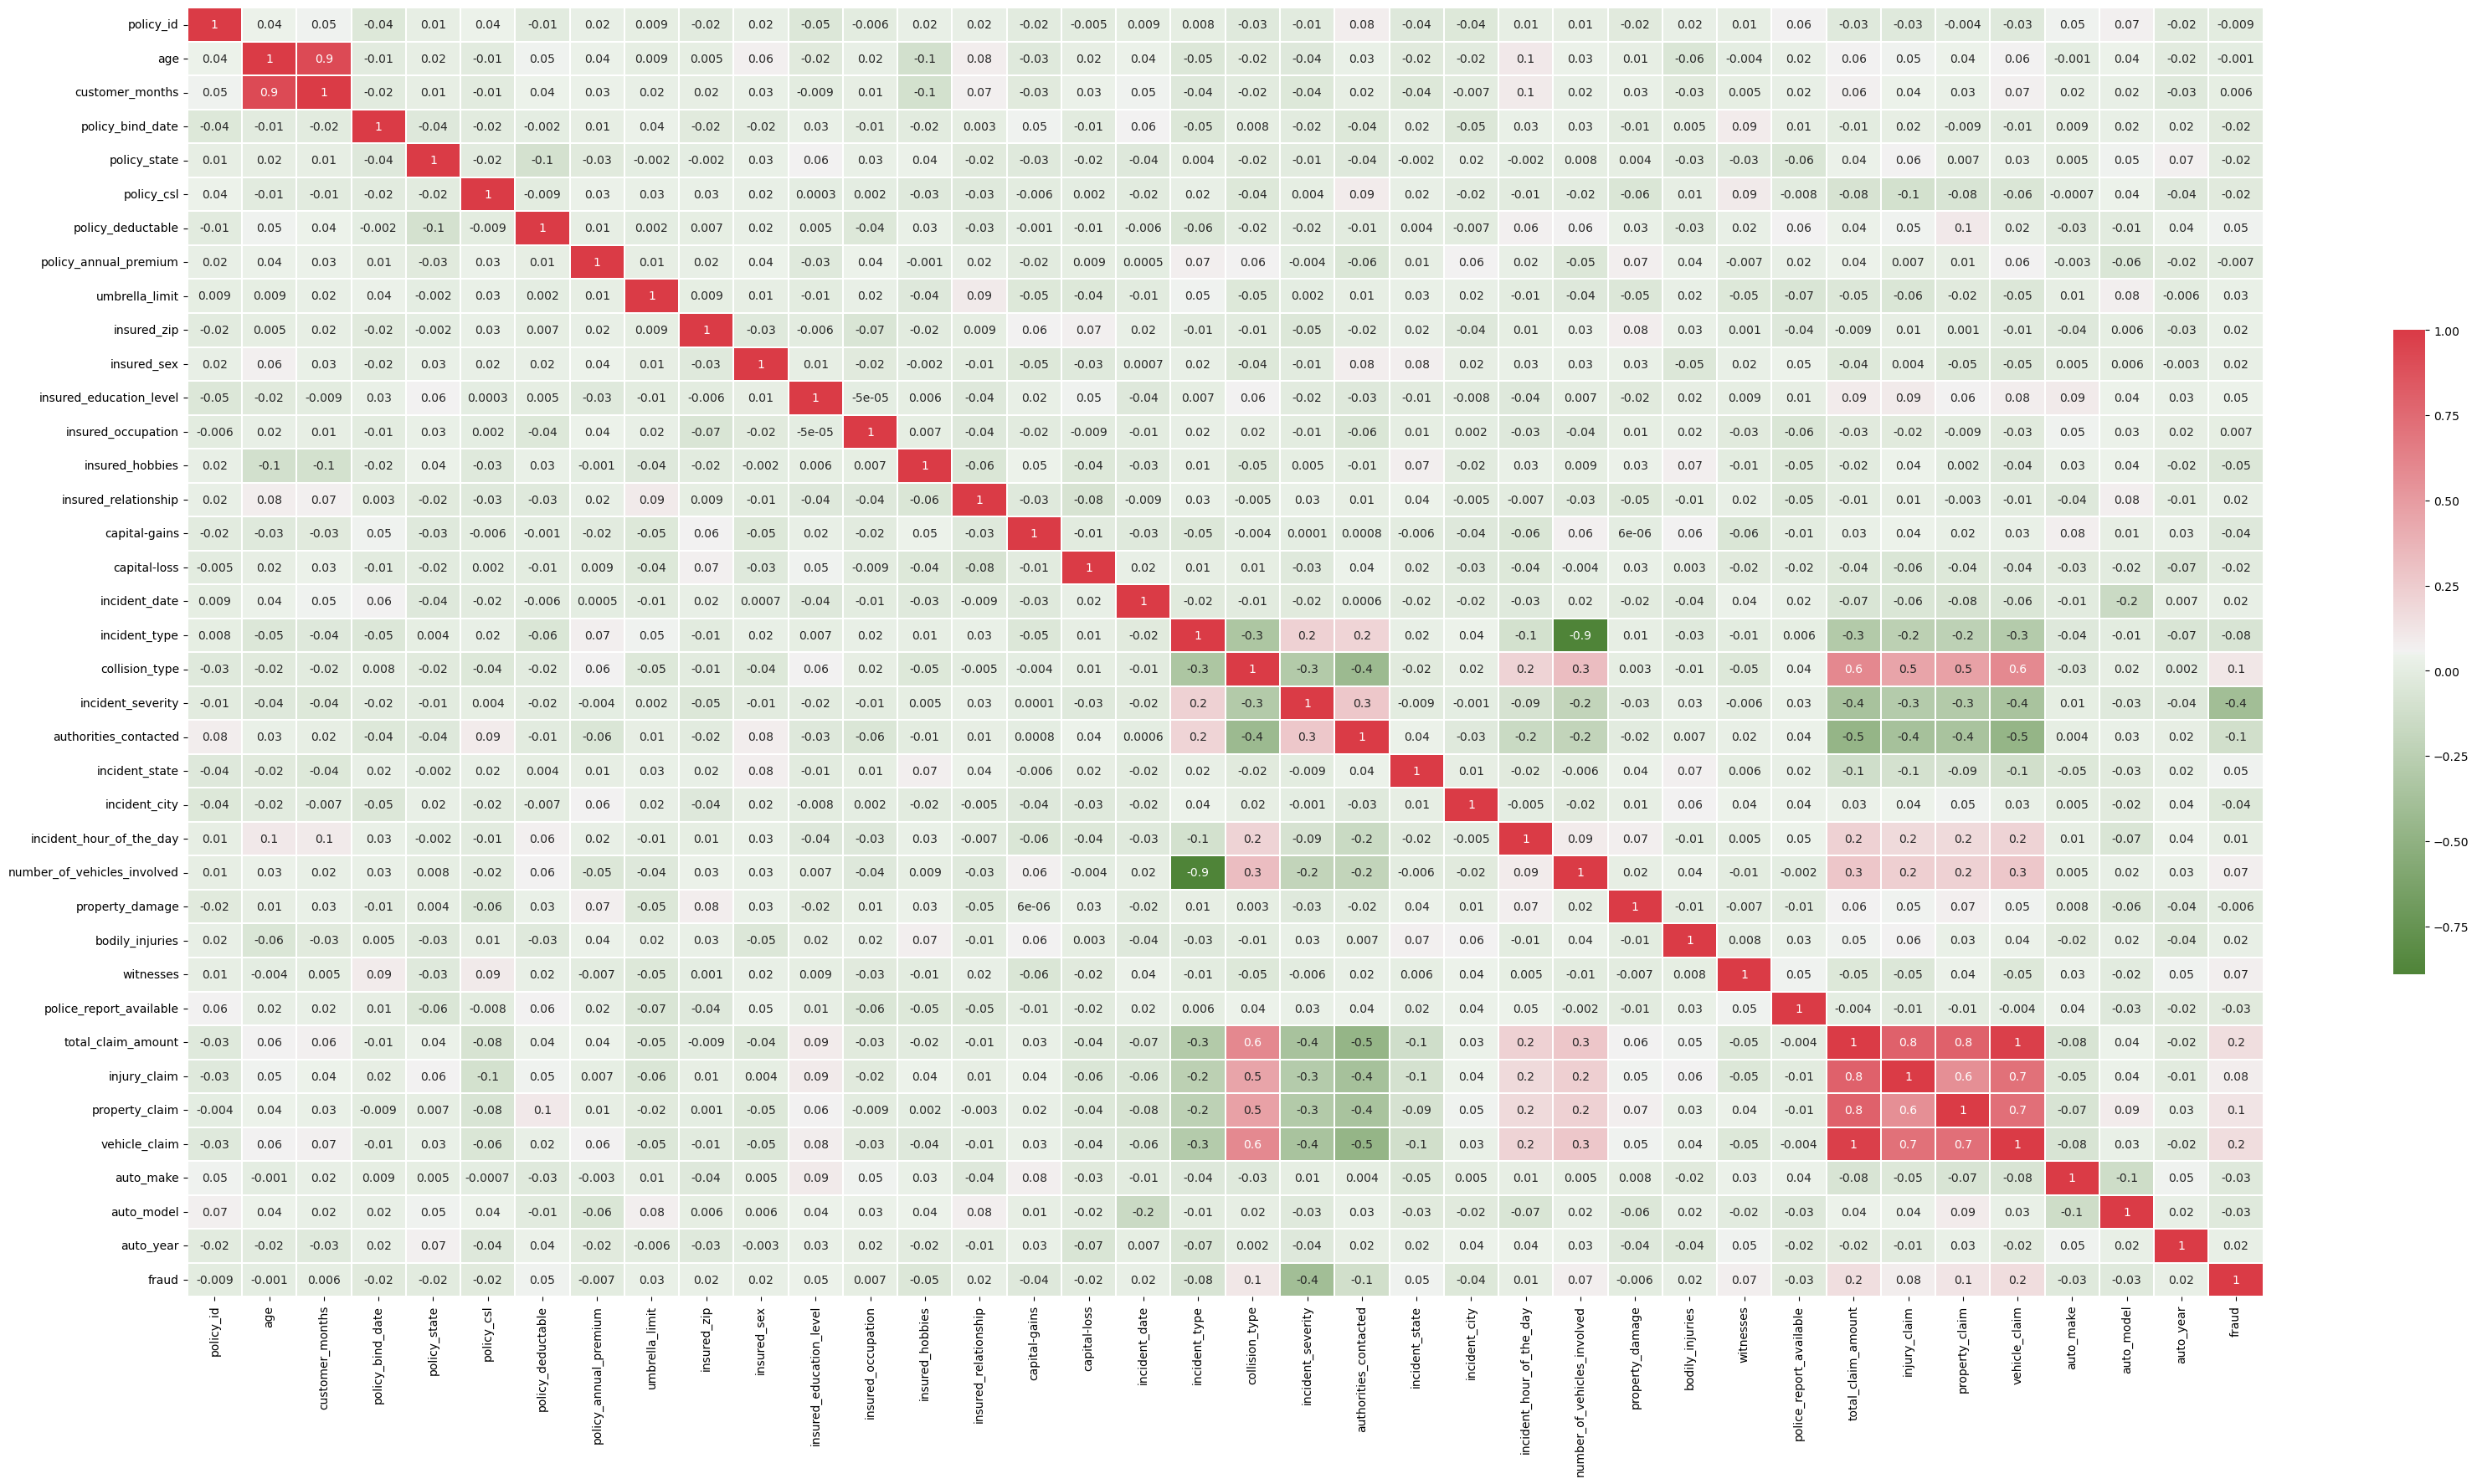

In [7]:
## 2.2 查看数据分布，查看数据分布是为了干什么，不懂，先跳过
## 2.3 查看相关性,生成热力图
cor = x_train.corr()
plt.figure(figsize=(40,20))
cmap = sns.diverging_palette(120, 10, as_cmap=True)
sns.heatmap(cor,cmap=cmap,annot = True,linewidth = 0.2,cbar_kws={"shrink": .5},linecolor = "white",fmt =".1g")
plt.show()

In [9]:
# 显示相关性高于0.6的变量
def getHighRelatedFeatureDf(corr_matrix, corr_threshold):
    highRelatedFeatureDf = pd.DataFrame(corr_matrix[corr_matrix > corr_threshold].stack().reset_index())
    highRelatedFeatureDf.rename({'level_0':'feature1','level_1':'feature2',0:'corr'},axis=1,inplace=True) # 更改列名
    highRelatedFeatureDf = highRelatedFeatureDf[highRelatedFeatureDf.feature1 != highRelatedFeatureDf.feature2] # 去除自己和自己
    highRelatedFeatureDf['feature_pair_key'] = highRelatedFeatureDf.loc[:,['feature1', 'feature2']].apply(lambda r:'#'.join(np.sort(r.values)), axis=1)
    # 将feature1和feature2名称连接在一起去重
    highRelatedFeatureDf.drop_duplicates(subset=['feature_pair_key'],inplace=True)
    highRelatedFeatureDf.drop(columns='feature_pair_key',inplace=True)
    return highRelatedFeatureDf

In [10]:
getHighRelatedFeatureDf(cor,0.6)

,feature1,feature2,corr
2,age,customer_months,0.92
33,total_claim_amount,injury_claim,0.80
34,total_claim_amount,property_claim,0.80
35,total_claim_amount,vehicle_claim,0.98
38,injury_claim,vehicle_claim,0.71
41,property_claim,vehicle_claim,0.72


In [11]:
## 去除相关性高的特征
for col in ['incident_date','age']: # ,
    del x_train[col]
    del x_test[col]

In [12]:
## 3. 样本划分
y_train = x_train['fraud']
x_train = x_train.drop(columns=['policy_id', 'fraud'])

# x_train_01,x_train_02,y_train_01,y_train_02 = train_test_split(x_train,y_train,train_size=0.7)

# x_train_01,x_train_02,y_train_01,y_train_02 = train_test_split(x_train,y_train,test_size=0.3,random_state=42)

# x_train_01, x_train_02 = train_test_split(x_train, test_size=0.3,random_state=42)  # 25% of remaining data as validation set
# y_train_01, y_train_02 = train_test_split(y_train, test_size=0.3, random_state=42)  # Split labels accordingly

In [13]:
## 4. 模型训练
# 4.1 GBDT模型
GBDT_param = {
    'loss': 'log_loss',
    'learning_rate': 0.1,
    'n_estimators': 30,
    'max_depth': 3,
    'min_samples_split': 300
}

GBDT_clf = GradientBoostingClassifier()  

# 4.2 决策树模型
tree_param = {
    'criterion': 'gini',
    'max_depth': 30,
    'min_impurity_decrease': 0.1,
    'min_samples_leaf': 2

}
Tree_clf = DecisionTreeClassifier(**tree_param)  #

# 4.3 xgboost模型
xgboost_param = {
    'learning_rate': 0.01,
    'reg_alpha': 0.,
    'max_depth': 3,
    'gamma': 0,
    'min_child_weight': 1

}



xgboost_clf = xgboost.XGBClassifier(**xgboost_param)

# xgboost_clf.fit(x_train_01, y_train_01)
# GBDT_clf.fit(x_train_01, y_train_01)
# Tree_clf.fit(x_train_01, y_train_01)

In [15]:
answers = []
mean_score = 0
n_folds = 10
sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2019)
for train, test in sk.split(x_train, y_train):
    x_train_01 = x_train.iloc[train]
    y_train_01 = y_train.iloc[train]
    x_train_02 = x_train.iloc[test]
    y_train_02 = y_train.iloc[test]
    
    xgboost_clf.fit(x_train_01, y_train_01)
#     clf = model.fit(x_train,y_train, eval_set=(x_test,y_test),verbose=500,cat_features=col)
    y_train_02_pred=xgboost_clf.predict_proba(x_train_02)[:,-1]
    print('cat验证的auc:{}'.format(roc_auc_score(y_train_02, y_train_02_pred)))
    mean_score += roc_auc_score(y_train_02, y_train_02_pred) / n_folds  ## 将n_folds次的auc值求了一个平均值
    print('--------mean_score---------')
    print(mean_score)
    
    y_test_pred = xgboost_clf.predict_proba(x_test.drop(columns=['policy_id']))[:,-1]
    print('--------y_pred_valid---------')
    print(y_test_pred)
    answers.append(y_test_pred)
    print('--------answers---------')
    print(answers)

print('10折平均Auc:{}'.format(mean_score))

cat验证的auc:0.782051282051282
--------mean_score---------
0.0782051282051282
--------y_pred_valid---------
[0.13105597 0.50264764 0.12504563 0.21587391 0.12504563 0.13105597
 0.15862153 0.12504563 0.12504563 0.12504563 0.15862153 0.12504563
 0.519461   0.12504563 0.12504563 0.31014138 0.13105597 0.13105597
 0.6152961  0.12504563 0.13105597 0.15862153 0.5291475  0.12504563
 0.15862153 0.38225302 0.13105597 0.15862153 0.6152961  0.12504563
 0.22888708 0.15862153 0.5538525  0.12504563 0.13105597 0.12504563
 0.5441072  0.12504563 0.12504563 0.12504563 0.5441072  0.12504563
 0.12504563 0.12504563 0.15862153 0.13105597 0.13105597 0.15862153
 0.43662742 0.12504563 0.13105597 0.12504563 0.12504563 0.5307348
 0.41486424 0.12504563 0.12504563 0.5338529  0.12504563 0.47287652
 0.13105597 0.12504563 0.12504563 0.519461   0.15862153 0.12504563
 0.6152961  0.50152385 0.13105597 0.13105597 0.12504563 0.17266619
 0.527007   0.6152961  0.12504563 0.12504563 0.15862153 0.12504563
 0.5096921  0.13105597 0.

--------y_pred_valid---------
[0.13105597 0.48276863 0.12895164 0.21955486 0.12895164 0.13105597
 0.12895164 0.12895164 0.12895164 0.12895164 0.12895164 0.12895164
 0.5414637  0.12895164 0.12895164 0.40450972 0.13105597 0.13105597
 0.61266226 0.12895164 0.13105597 0.12895164 0.5479446  0.12895164
 0.12895164 0.44325143 0.13105597 0.12895164 0.61266226 0.12895164
 0.3703601  0.12895164 0.52361363 0.12895164 0.13105597 0.12895164
 0.4887188  0.12895164 0.12895164 0.12895164 0.51952136 0.12895164
 0.12895164 0.12895164 0.12895164 0.13105597 0.13105597 0.12895164
 0.4634754  0.12895164 0.13105597 0.12895164 0.12895164 0.51989365
 0.47025722 0.12895164 0.12895164 0.528044   0.12895164 0.47202003
 0.13105597 0.12895164 0.12895164 0.47280577 0.12895164 0.12895164
 0.61266226 0.51952136 0.13105597 0.13105597 0.12895164 0.21955486
 0.47651705 0.61266226 0.12895164 0.12895164 0.12895164 0.12895164
 0.4950189  0.13105597 0.13105597 0.13105597 0.4528217  0.13105597
 0.13105597 0.12895164 0.1289516

cat验证的auc:0.9326923076923077
--------mean_score---------
0.594284188034188
--------y_pred_valid---------
[0.12927301 0.55414265 0.13201053 0.18170145 0.13201053 0.12927301
 0.14807725 0.13201053 0.13201053 0.13201053 0.14807725 0.13201053
 0.42832753 0.13201053 0.13201053 0.45761338 0.12927301 0.12927301
 0.59752846 0.13201053 0.12927301 0.14807725 0.54627454 0.13201053
 0.14807725 0.4645034  0.12927301 0.14807725 0.59752846 0.13201053
 0.29695022 0.17488502 0.5283074  0.13201053 0.12927301 0.13201053
 0.544381   0.13201053 0.13201053 0.13201053 0.5380583  0.13201053
 0.13201053 0.13201053 0.14807725 0.12927301 0.12927301 0.14807725
 0.51596546 0.13201053 0.12927301 0.13201053 0.13201053 0.54903775
 0.52279824 0.13201053 0.13201053 0.5219471  0.13201053 0.5295731
 0.12927301 0.13201053 0.13201053 0.4782562  0.14807725 0.13201053
 0.59752846 0.53154635 0.12927301 0.12927301 0.13201053 0.16268311
 0.4782562  0.59752846 0.13201053 0.13201053 0.14807725 0.13201053
 0.5446513  0.12927301 0.

cat验证的auc:0.8498931623931624
--------mean_score---------
0.7595619658119659
--------y_pred_valid---------
[0.12976012 0.43024865 0.13166727 0.1413668  0.13166727 0.12976012
 0.1413668  0.13166727 0.13166727 0.13166727 0.1413668  0.13166727
 0.5914093  0.13166727 0.13166727 0.4379941  0.12976012 0.12976012
 0.6313625  0.13166727 0.12976012 0.1413668  0.47741726 0.13166727
 0.1413668  0.4956919  0.12976012 0.1413668  0.6313625  0.13367994
 0.45195806 0.178626   0.49550703 0.13166727 0.12976012 0.13166727
 0.3963666  0.13323747 0.13166727 0.13166727 0.49029315 0.13166727
 0.13166727 0.13166727 0.14299671 0.12976012 0.12976012 0.1413668
 0.47275114 0.13367994 0.12976012 0.13166727 0.13166727 0.36113653
 0.34640452 0.13166727 0.13166727 0.43746188 0.13320272 0.5725925
 0.12976012 0.13367994 0.13166727 0.53268355 0.14350323 0.13166727
 0.6313625  0.48273012 0.12976012 0.12976012 0.13166727 0.13166727
 0.4797913  0.6313625  0.13166727 0.13166727 0.1413668  0.13166727
 0.5401705  0.12976012 0.

In [16]:
# 5. 模型评估
# 5.1 K折交叉检验
K_model_list = [xgboost_clf] # Tree_clf,GBDT_clf
K_result = pd.DataFrame()
for i,val in enumerate(K_model_list):
    score = cross_validate(val,x_train,y_train,cv=6,scoring='accuracy') #cv=6，表示6折交叉
    K_result.loc[i,'accuracy'] = score['test_score'].mean()
K_result.index = pd.Series(['XGBoost']) # 'Tree','GBDT',
K_result

,accuracy
XGBoost,0.80


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

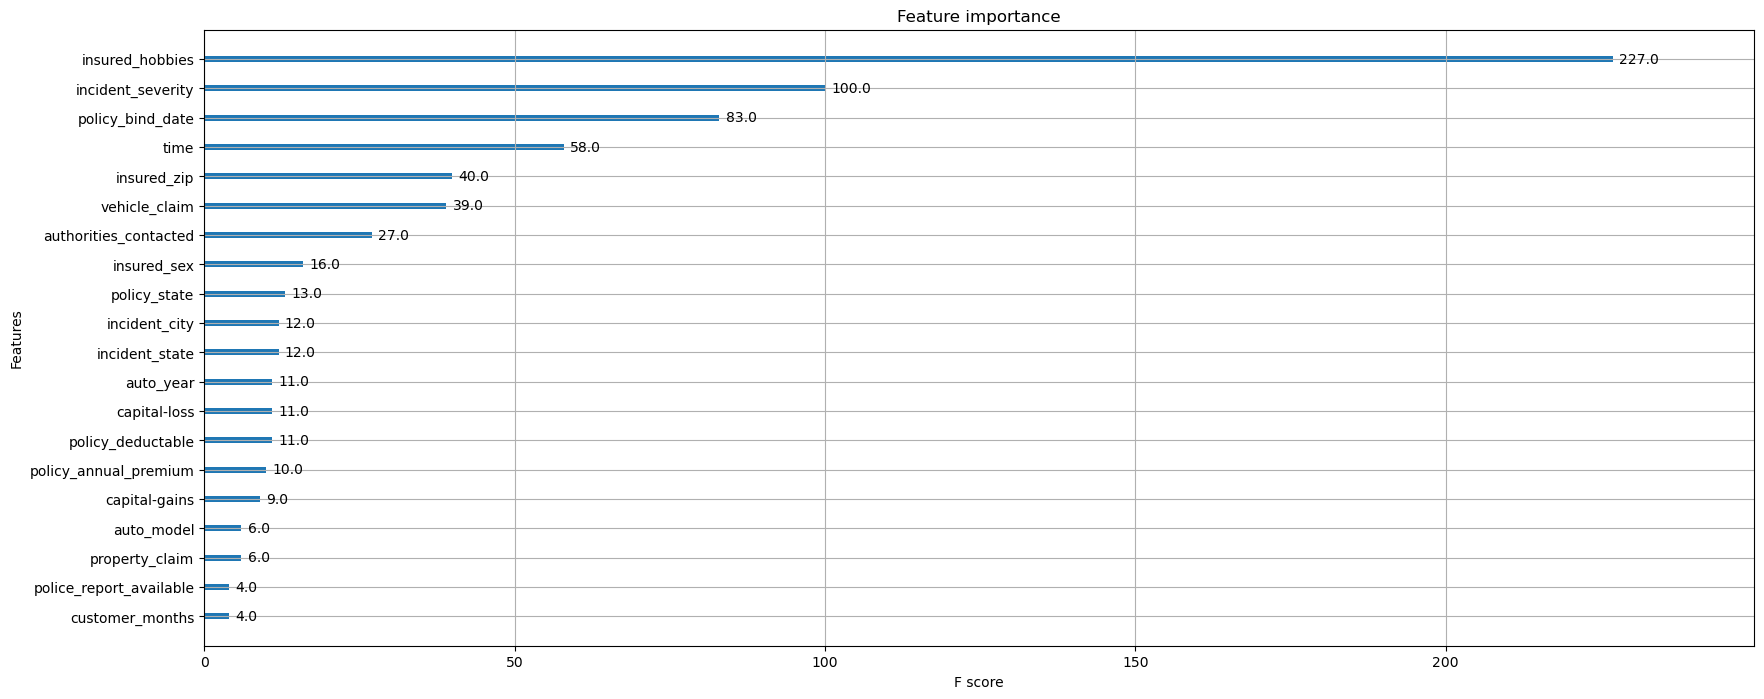

In [17]:
## 5.2 指标重要性排序
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(20,8))
plot_importance(xgboost_clf,ax=ax)

In [36]:
## 6. 结果输出
## 6.1 测试集测试

# y_test_pred=sum(answers)/n_folds
# model_name = 'model_v20240430_1810'
# result = pd.read_csv('./data/submission.csv')
# result['fraud'] = y_test_pred
# result.to_csv(f'./data/{model_name}.csv', index=False)